In [27]:
from self_shade import shade_fractions, non_linear_shade, plant_power_with_shade_losses
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5, style='white')
mpl.rcParams['figure.figsize'] = (12, 8)
print(f'pvlib version: {pvlib.__version__}')

pvlib version: 0.10.4


In [28]:
filename = 'plant_specs_pvpmc_rev2.csv'
header = 4 # row (0-index, so starting count at 0) of the header
index_col = 'None'
plants_df = pd.read_csv(filename, header=header).set_index('unit_id') # read in as a Pandas DataFrame
num_plants = len(plants_df.index) # number of plants

In [29]:
## API key credentials are stored in a separate text file
try:
    with open('credentials/nrel_api_key_details.txt') as f: # full path and filename of text file with email on first line and api key on second line
        email = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces
        api_key = f.readline().rstrip()
except:
    print('error with email and API key, using temporary defaults')
    print('register at https://developer.nrel.gov/')
    print('create the folder and text file referenced above with email on first line and API key on second line')
    api_key = 'DEMO_KEY'
    email = 'your_email@domain.com'

In [33]:
def make_no_shade_power_plot(unit_id, plant_data, times, plot_title):
    # read in normalized observed power from a reference plant
    power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                            index_col=0,
                            parse_dates=["UTC"])
    power_obs.index = power_obs.index.tz_localize('UTC')

    # get nsrdb data.
    names = times.min().year
    if names >= 2018:
        interval = 5
    else:
        interval = 30

    resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                    plant_data['longitude'],
                                                    api_key,
                                                    email,
                                                    names=names,
                                                    interval=interval,
                                                    attributes=[], # get all attributes
                                                    map_variables=True,
                                                    leap_day=True,
                                                    )

    # convert to UTC, adjust metadata to match
    resource_data.index = resource_data.index.tz_convert('UTC')
    metadata['Time Zone'] = 0

    # just use clear sky
    resource_data.ghi = resource_data.ghi_clear
    resource_data.dhi = resource_data.dhi_clear
    resource_data.dni = resource_data.dni_clear

    power_ac_modeled, _ = plant_power_with_shade_losses(resource_data, **plant_data)

    # negligible shade w/ linear loss model
    plant_data_new = { **plant_data,
                    'gcr':0.00000001,
                    'row_side_num_mods':1,
                    'shade_loss_type':'linear',
                    'cell_type':'thin-film',
                    }
    power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

    f, ax = plt.subplots(1, 1)
    # (power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_no_shade.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
    (power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax,)
    (power_obs.observed_power.loc[times[0]:times[-1]] / power_obs.observed_power.loc[times[0]:times[-1]].max()).plot(ax=ax)
    

    plt.legend(['modeled power (no shade)', 'observation'])
    plt.xlim([times.min(), times.max()])
    # plt.ylim([-0.01,None])
    plt.title(plot_title)

c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


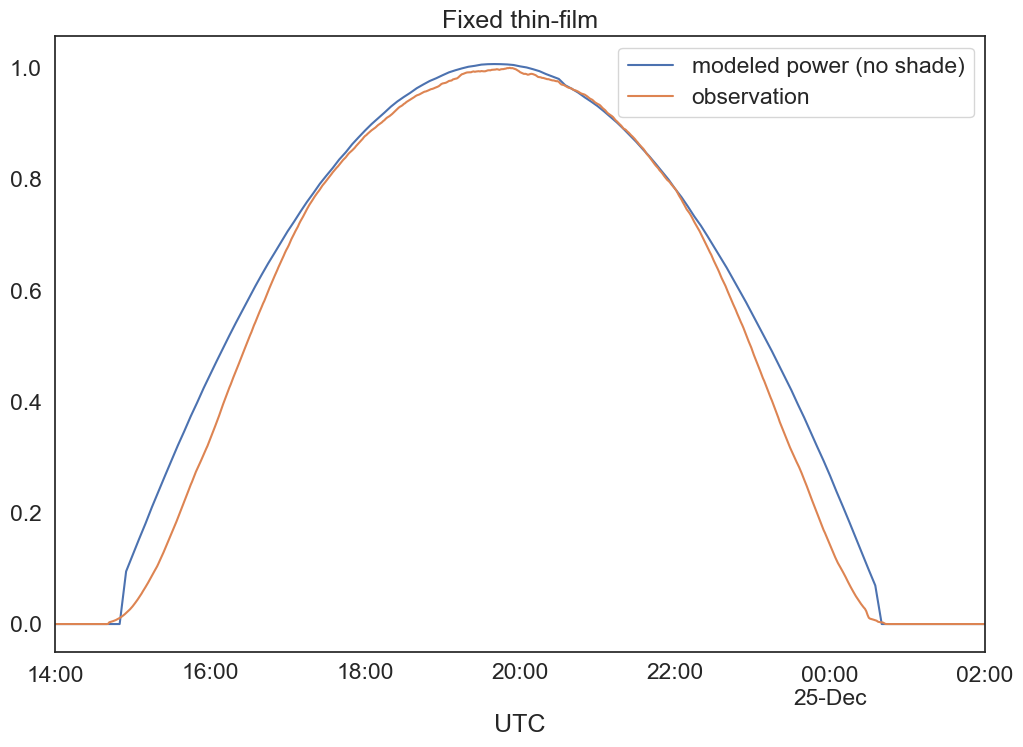

In [37]:
# pick plant/inv unit number:
unit_id = 60

# date range with clear sky data for the plant
times = pd.date_range('2022-12-24 14:00', '2022-12-25 02:00', freq='5min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

plot_title = 'Fixed thin-film'
make_no_shade_power_plot(unit_id, plant_data, times, plot_title)

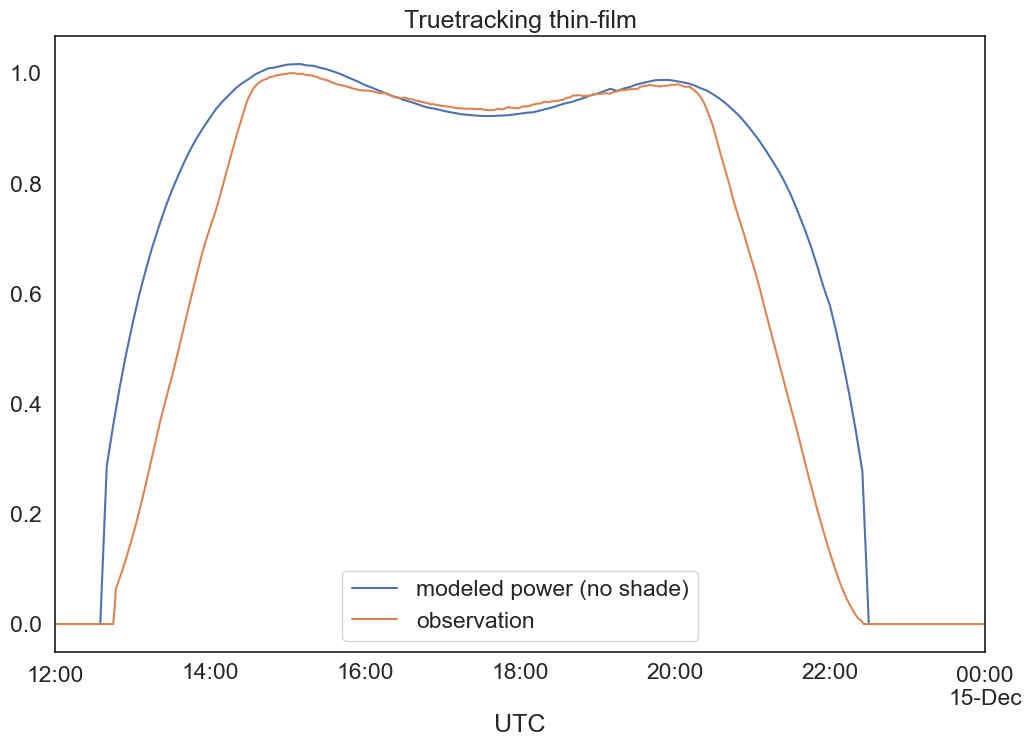

In [35]:
# pick plant/inv unit number:
unit_id = 20

# date range with clear sky data for the plant
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

plot_title = 'Truetracking thin-film'
make_no_shade_power_plot(unit_id, plant_data, times, plot_title)

c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


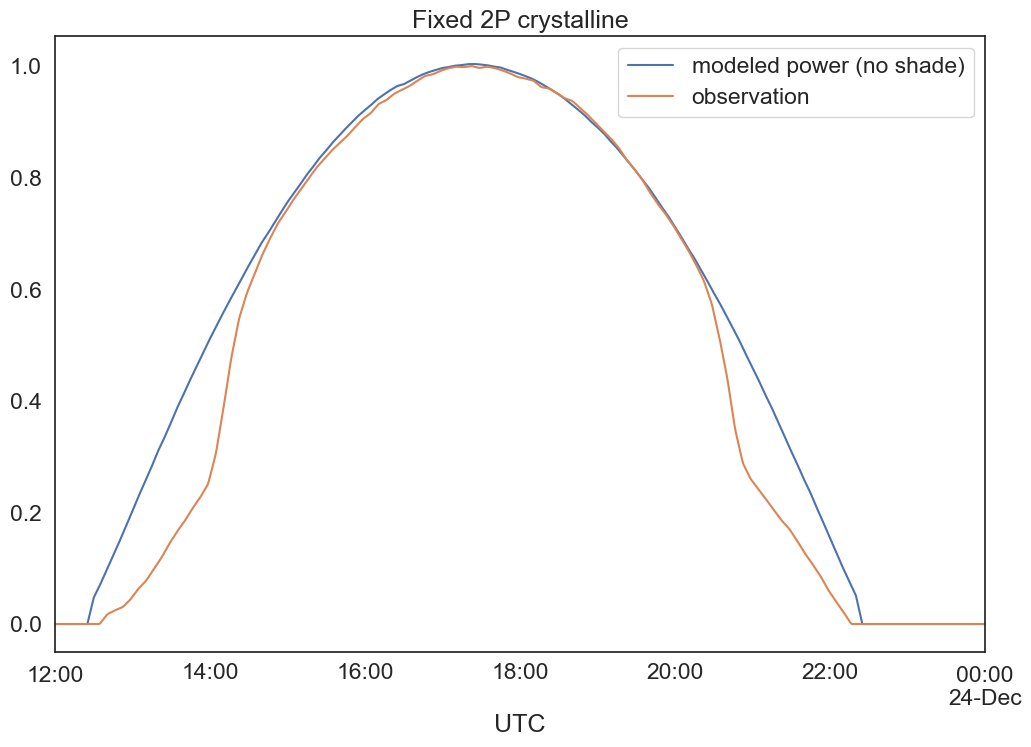

In [38]:
# pick plant/inv unit number:
unit_id = 50

# date range with clear sky data for the plant
times = pd.date_range('2021-12-23 12:00', '2021-12-24 00:00', freq='5min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

plot_title = 'Fixed 2P crystalline'
make_no_shade_power_plot(unit_id, plant_data, times, plot_title)

c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


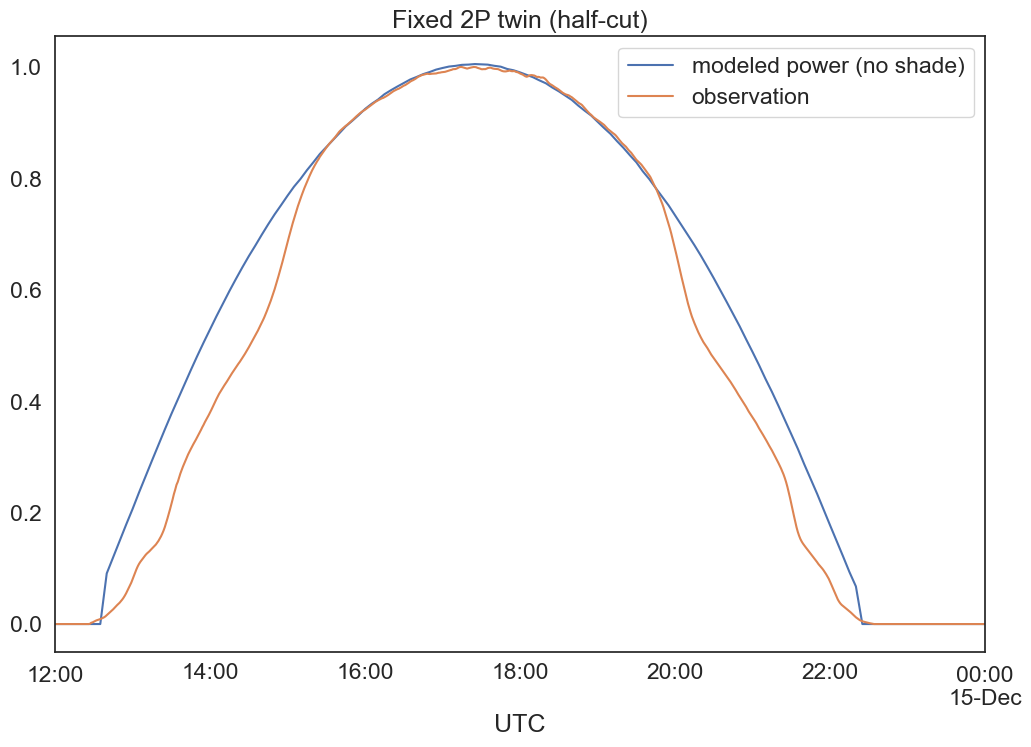

In [39]:
# pick plant/inv unit number:
unit_id = 40

# date range with clear sky data for the plant
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
\

plot_title = 'Fixed 2P twin (half-cut)'
make_no_shade_power_plot(unit_id, plant_data, times, plot_title)